In [ ]:
# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc  
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
# plt.style.use('seaborn')

In [4]:
# Read the fields data
fields_df = pd.read_csv('SciSciNet_Fields.tsv', sep='\t')
print("Fields shape:", fields_df.shape)
print("\nSample fields:")
print(fields_df.head())

Fields shape: (311, 3)

Sample fields:
     FieldID               Field_Name Field_Type
0    3079626  Quantum electrodynamics        Sub
1   37914503     Mathematical physics        Sub
2  159047783                 Virology        Sub
3   70410870      Clinical psychology        Sub
4  187212893               Pediatrics        Sub


In [5]:
def read_large_tsv(filename, chunksize=100000):
    """
    Read large TSV files in chunks and return basic statistics
    """
    chunks = pd.read_csv(filename, sep='\t', chunksize=chunksize)
    
    total_rows = 0
    sample_df = None
    
    print(f"Processing {filename}...")
    
    for i, chunk in enumerate(chunks):
        if i == 0:
            sample_df = chunk.head()
            print("\nColumns:", chunk.columns.tolist())
            print("\nDtypes:\n", chunk.dtypes)
        
        total_rows += len(chunk)
        
        # Free memory
        del chunk
        gc.collect()
    
    print(f"\nTotal rows: {total_rows:,}")
    return sample_df

In [6]:
# Get basic statistics of the papers dataset
papers_sample = read_large_tsv('SciSciNet_Papers.tsv', chunksize=500000)
print("\nSample papers:")
print(papers_sample)

Processing SciSciNet_Papers.tsv...

Columns: ['PaperID', 'DOI', 'DocType', 'Year', 'Date', 'JournalID', 'ConferenceSeriesID', 'Citation_Count', 'C10', 'Reference_Count', 'C5', 'Team_Size', 'Institution_Count', 'Disruption', 'Atyp_10pct_Z', 'Atyp_Pairs', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Patent_Count', 'Newsfeed_Count', 'Tweet_Count', 'NCT_Count', 'NIH_Count', 'NSF_Count', 'WSB_mu', 'WSB_sigma', 'WSB_Cinf']

Dtypes:
 PaperID                 int64
DOI                    object
DocType                object
Year                  float64
Date                   object
JournalID             float64
ConferenceSeriesID    float64
Citation_Count        float64
C10                   float64
Reference_Count       float64
C5                    float64
Team_Size             float64
Institution_Count     float64
Disruption            float64
Atyp_10pct_Z          float64
Atyp_Pairs            float64
Atyp_Median_Z         float64
SB_B                  float64
SB_T                  float64
Patent_Cou

In [ ]:
read_large_tsv("SciSciNet_PaperAuthorAffiliations.tsv")

FileNotFoundError: [Errno 2] No such file or directory: 'SciSciNet_PaperAuthorAffiliations.tsv'

Processing citations: 269it [01:36,  2.80it/s]


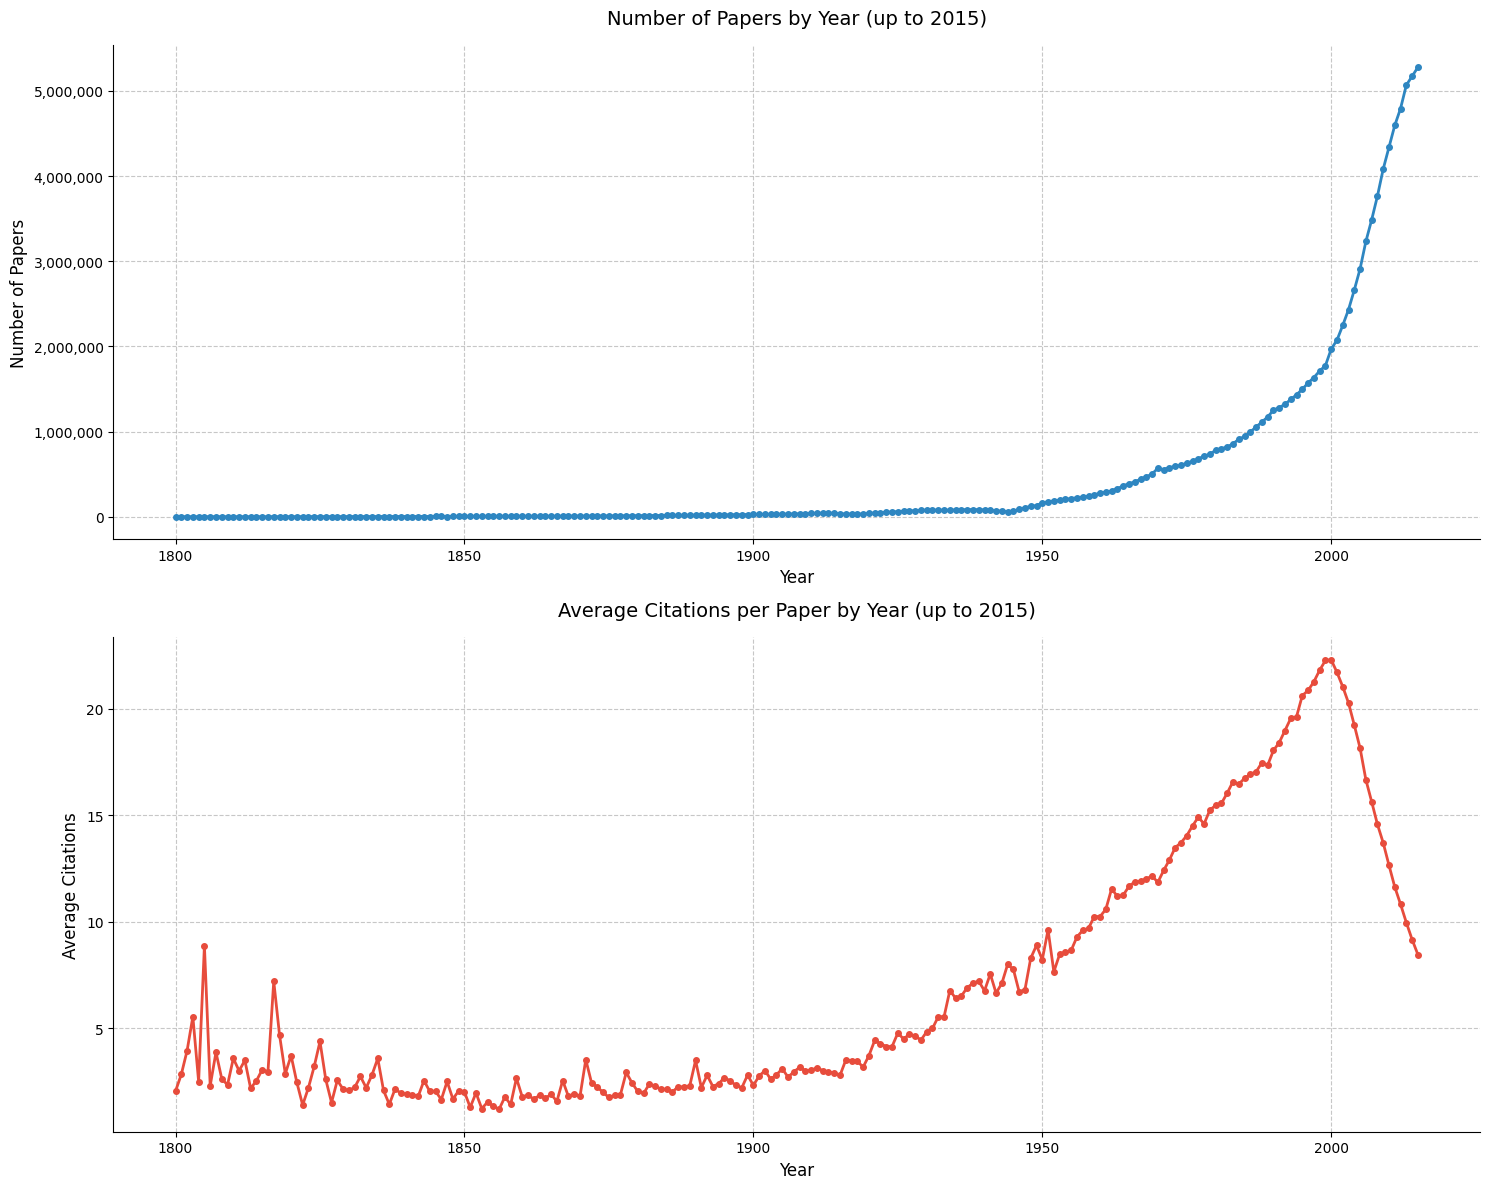


Summary Statistics (1900-2015):
Total number of papers: 98,204,169.0
Average citations per paper: 14.64
Maximum citations for a single paper: 270,903.0

Top 5 years by paper count:
2015.0    5275950.0
2014.0    5171978.0
2013.0    5066484.0
2012.0    4792219.0
2011.0    4594106.0
Name: count, dtype: float64


In [9]:
def analyze_citations_by_year(chunksize=500000, end_year=2015):
    """
    Analyze citation patterns over years up to specified end_year
    """
    year_stats = {}
    
    chunks = pd.read_csv('SciSciNet_Papers.tsv', sep='\t', 
                        usecols=['Year', 'Citation_Count'],
                        chunksize=chunksize)
    
    for chunk in tqdm(chunks, desc="Processing citations"):
        # Ensure Year and Citation_Count are numeric
        chunk['Year'] = pd.to_numeric(chunk['Year'], errors='coerce')
        chunk['Citation_Count'] = pd.to_numeric(chunk['Citation_Count'], errors='coerce')
        
        # Remove any NaN values and filter years
        chunk = chunk[chunk['Year'] <= end_year].dropna()
        
        # Group by year and calculate statistics
        year_group = chunk.groupby('Year').agg({
            'Citation_Count': ['count', 'sum', 'max']
        })
        
        # Update statistics
        for year in year_group.index:
            if year not in year_stats:
                year_stats[year] = {
                    'count': 0,
                    'total_citations': 0,
                    'max_citations': 0
                }
            
            stats = year_group.loc[year]
            year_stats[year]['count'] += stats[('Citation_Count', 'count')]
            year_stats[year]['total_citations'] += stats[('Citation_Count', 'sum')]
            year_stats[year]['max_citations'] = max(year_stats[year]['max_citations'], 
                                                  stats[('Citation_Count', 'max')])
        
        del chunk
        gc.collect()
    
    # Convert to DataFrame
    citation_trends = pd.DataFrame.from_dict(year_stats, orient='index')
    citation_trends['avg_citations'] = citation_trends['total_citations'] / citation_trends['count']
    citation_trends.index = pd.to_numeric(citation_trends.index)  # Ensure index is numeric
    citation_trends = citation_trends.sort_index()
    
    return citation_trends

# Run the citation analysis up to 2015
citation_trends = analyze_citations_by_year(end_year=2015)

# Create figure with improved styling
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Papers per year with improved styling
ax1.plot(citation_trends.index, citation_trends['count'], 
         color='#2E86C1', linewidth=2, marker='o', markersize=4)
ax1.set_title('Number of Papers by Year (up to 2015)', fontsize=14, pad=15)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Average citations per year with improved styling
ax2.plot(citation_trends.index, citation_trends['avg_citations'], 
         color='#E74C3C', linewidth=2, marker='o', markersize=4)
ax2.set_title('Average Citations per Paper by Year (up to 2015)', fontsize=14, pad=15)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Average Citations', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add thousand separator to y-axis
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSummary Statistics (1900-2015):")
print(f"Total number of papers: {citation_trends['count'].sum():,}")
print(f"Average citations per paper: {citation_trends['total_citations'].sum() / citation_trends['count'].sum():.2f}")
print(f"Maximum citations for a single paper: {citation_trends['max_citations'].max():,}")
print("\nTop 5 years by paper count:")
print(citation_trends['count'].sort_values(ascending=False).head())

Processing C10 citations: 269it [01:57,  2.29it/s]


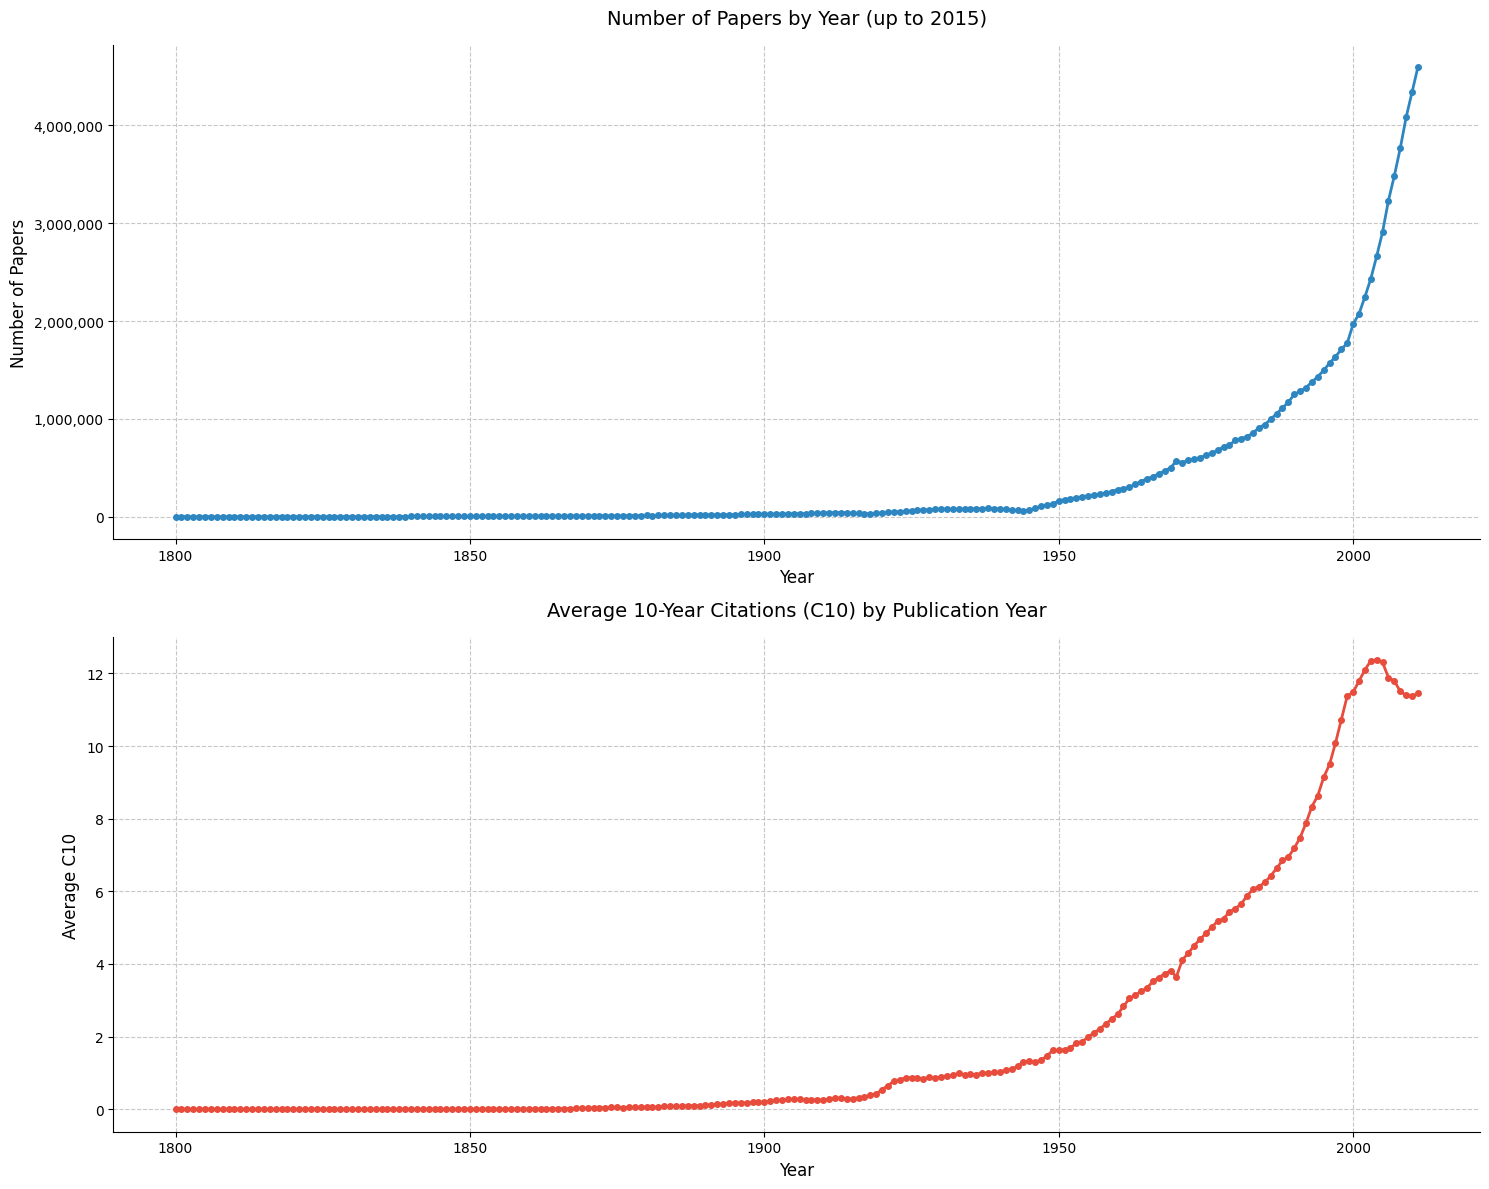


Summary Statistics for C10 (1900-2015):
Total number of papers: 77,897,538.0
Average C10 across all papers: 8.85
Maximum C10 for a single paper: 64,193.0

Top 5 years by average C10:
2004.0    12.374215
2003.0    12.346609
2005.0    12.304218
2002.0    12.096357
2006.0    11.883636
Name: avg_c10, dtype: float64


In [11]:
def analyze_c10_by_year(chunksize=500000, end_year=2015):
    """
    Analyze 10-year citation patterns (C10) over years
    """
    year_stats = {}
    
    chunks = pd.read_csv('SciSciNet_Papers.tsv', sep='\t', 
                        usecols=['Year', 'C10'],
                        chunksize=chunksize)
    
    for chunk in tqdm(chunks, desc="Processing C10 citations"):
        # Ensure Year and C10 are numeric
        chunk['Year'] = pd.to_numeric(chunk['Year'], errors='coerce')
        chunk['C10'] = pd.to_numeric(chunk['C10'], errors='coerce')
        
        # Remove any NaN values and filter years
        # Since we need 10 years for citations to accumulate, we'll stop at end_year
        chunk = chunk[chunk['Year'] <= end_year].dropna()
        
        # Group by year and calculate statistics
        year_group = chunk.groupby('Year').agg({
            'C10': ['count', 'mean', 'max']
        })
        
        # Update statistics
        for year in year_group.index:
            if year not in year_stats:
                year_stats[year] = {
                    'count': 0,
                    'avg_c10': 0,
                    'max_c10': 0,
                    'total_c10': 0
                }
            
            stats = year_group.loc[year]
            count = stats[('C10', 'count')]
            mean_c10 = stats[('C10', 'mean')]
            
            # Update running statistics
            current_total = year_stats[year]['total_c10']
            current_count = year_stats[year]['count']
            new_total = current_total + (mean_c10 * count)
            new_count = current_count + count
            
            year_stats[year]['count'] = new_count
            year_stats[year]['total_c10'] = new_total
            year_stats[year]['avg_c10'] = new_total / new_count
            year_stats[year]['max_c10'] = max(year_stats[year]['max_c10'], 
                                            stats[('C10', 'max')])
        
        del chunk
        gc.collect()
    
    # Convert to DataFrame
    citation_trends = pd.DataFrame.from_dict(year_stats, orient='index')
    citation_trends.index = pd.to_numeric(citation_trends.index)  # Ensure index is numeric
    citation_trends = citation_trends.sort_index()
    
    return citation_trends

# Run the C10 analysis up to 2015
citation_trends = analyze_c10_by_year(end_year=2015)

# Create figure with improved styling
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Papers per year with improved styling
ax1.plot(citation_trends.index, citation_trends['count'], 
         color='#2E86C1', linewidth=2, marker='o', markersize=4)
ax1.set_title('Number of Papers by Year (up to 2015)', fontsize=14, pad=15)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Average C10 per year with improved styling
ax2.plot(citation_trends.index, citation_trends['avg_c10'], 
         color='#E74C3C', linewidth=2, marker='o', markersize=4)
ax2.set_title('Average 10-Year Citations (C10) by Publication Year', fontsize=14, pad=15)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Average C10', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add thousand separator to y-axis
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSummary Statistics for C10 (1900-2015):")
print(f"Total number of papers: {citation_trends['count'].sum():,}")
print(f"Average C10 across all papers: {citation_trends['total_c10'].sum() / citation_trends['count'].sum():.2f}")
print(f"Maximum C10 for a single paper: {citation_trends['max_c10'].max():,}")
print("\nTop 5 years by average C10:")
print(citation_trends['avg_c10'].sort_values(ascending=False).head())

Fields data shape: (311, 3)

Sample of fields data:
     FieldID               Field_Name Field_Type
0    3079626  Quantum electrodynamics        Sub
1   37914503     Mathematical physics        Sub
2  159047783                 Virology        Sub
3   70410870      Clinical psychology        Sub
4  187212893               Pediatrics        Sub
Getting 2015 papers...


269it [01:07,  4.00it/s]



Found 5,275,950 papers from 2015

Analyzing field distributions...


555it [16:37,  1.80s/it]



Top 10 Subjects in 2015:
                        Field_Name   count
126322002        Internal medicine  280414
141071460                  Surgery  172806
154945302  Artificial intelligence  117909
203014093               Immunology   84629
134018914            Endocrinology   83710
142724271                Pathology   82066
159985019       Composite material   77707
15708023                Humanities   73063
120665830                   Optics   69059
171250308           Nanotechnology   68152

Top 10 Topics in 2015:
                  Field_Name   count
71924100            Medicine  983205
86803240             Biology  431345
41008148    Computer science  411199
192562407  Materials science  384387
185592680          Chemistry  340292
127413603        Engineering  285934
15744967          Psychology  261898
33923547         Mathematics  193336
17744445   Political science  169940
121332964            Physics  168874


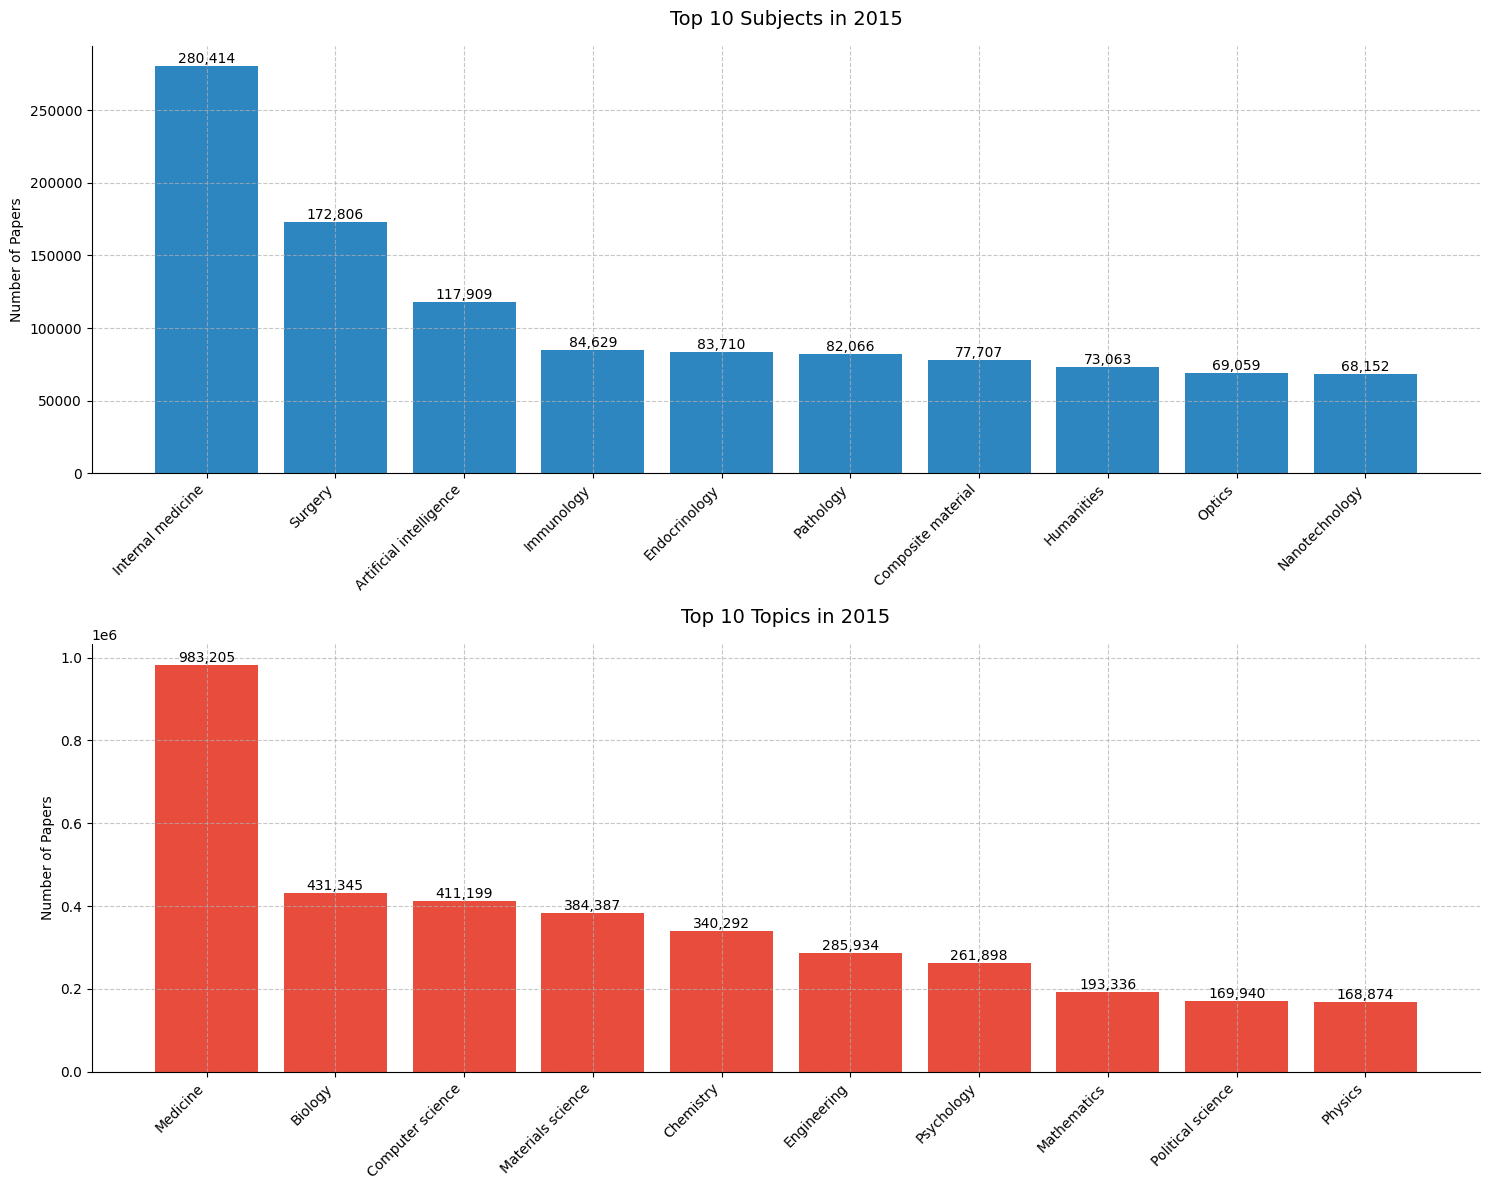


Total papers with subject classifications in 2015: 6,678,141

Subject distribution (percentage):
Internal medicine: 4.20%
Surgery: 2.59%
Artificial intelligence: 1.77%
Immunology: 1.27%
Endocrinology: 1.25%
Pathology: 1.23%
Composite material: 1.16%
Humanities: 1.09%
Optics: 1.03%
Nanotechnology: 1.02%


In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# First load the fields data
fields_df = pd.read_csv('SciSciNet_Fields.tsv', sep='\t')
print("Fields data shape:", fields_df.shape)
print("\nSample of fields data:")
print(fields_df.head())

def analyze_fields_2015(chunksize=500000):
    """
    Analyze field distributions for 2015 papers
    """
    # Create dictionaries to store field statistics
    field_stats = {}
    
    # Read PaperFields in chunks
    chunks = pd.read_csv('SciSciNet_PaperFields.tsv', sep='\t', 
                        usecols=['PaperID', 'FieldID'],
                        chunksize=chunksize)
    
    # Get papers from 2015
    papers_2015 = set()
    paper_chunks = pd.read_csv('SciSciNet_Papers.tsv', sep='\t',
                              usecols=['PaperID', 'Year'],
                              chunksize=chunksize)
    
    print("Getting 2015 papers...")
    for chunk in tqdm(paper_chunks):
        papers_2015.update(chunk[chunk['Year'] == 2015]['PaperID'].tolist())
    
    print(f"\nFound {len(papers_2015):,} papers from 2015")
    
    print("\nAnalyzing field distributions...")
    for chunk in tqdm(chunks):
        # Filter for 2015 papers
        chunk = chunk[chunk['PaperID'].isin(papers_2015)]
        
        # Count fields
        field_counts = chunk['FieldID'].value_counts()
        
        # Update overall counts
        for field_id, count in field_counts.items():
            if field_id not in field_stats:
                field_stats[field_id] = 0
            field_stats[field_id] += count
        
        del chunk
    
    # Convert to DataFrame and merge with field information
    field_dist = pd.DataFrame.from_dict(field_stats, orient='index', columns=['count'])
    field_dist = field_dist.join(fields_df.set_index('FieldID'))
    
    return field_dist

# Run the analysis
field_distribution = analyze_fields_2015()

# Get top 10 Subjects
top_subjects = field_distribution[field_distribution['Field_Type'] == 'Sub'].sort_values('count', ascending=False).head(10)
print("\nTop 10 Subjects in 2015:")
print(top_subjects[['Field_Name', 'count']].to_string())

# Get top 10 Topics
top_topics = field_distribution[field_distribution['Field_Type'] == 'Top'].sort_values('count', ascending=False).head(10)
print("\nTop 10 Topics in 2015:")
print(top_topics[['Field_Name', 'count']].to_string())

# Create visualization
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot top subjects
bars1 = ax1.bar(range(len(top_subjects)), top_subjects['count'], color='#2E86C1')
ax1.set_title('Top 10 Subjects in 2015', fontsize=14, pad=15)
ax1.set_xticks(range(len(top_subjects)))
ax1.set_xticklabels(top_subjects['Field_Name'], rotation=45, ha='right')
ax1.set_ylabel('Number of Papers')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot top topics
bars2 = ax2.bar(range(len(top_topics)), top_topics['count'], color='#E74C3C')
ax2.set_title('Top 10 Topics in 2015', fontsize=14, pad=15)
ax2.set_xticks(range(len(top_topics)))
ax2.set_xticklabels(top_topics['Field_Name'], rotation=45, ha='right')
ax2.set_ylabel('Number of Papers')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add value labels on bars
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

add_value_labels(ax1, bars1)
add_value_labels(ax2, bars2)

plt.tight_layout()
plt.show()

# Calculate percentages
total_papers_2015 = field_distribution[field_distribution['Field_Type'] == 'Sub']['count'].sum()
print(f"\nTotal papers with subject classifications in 2015: {total_papers_2015:,}")

print("\nSubject distribution (percentage):")
for _, row in top_subjects.iterrows():
    percentage = (row['count'] / total_papers_2015) * 100
    print(f"{row['Field_Name']}: {percentage:.2f}%")